Eposchs:: 100%|██████████| 80/80 [00:09<00:00,  8.56it/s]


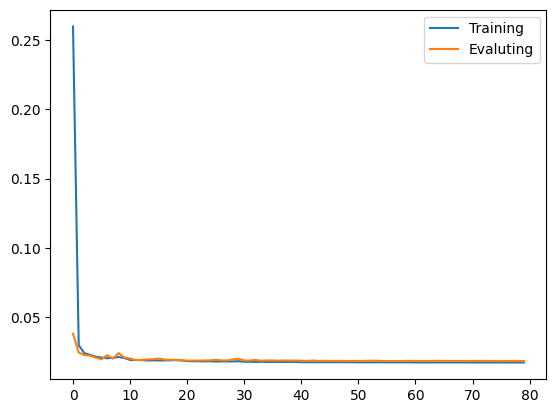

R2 Score is:  0.9816


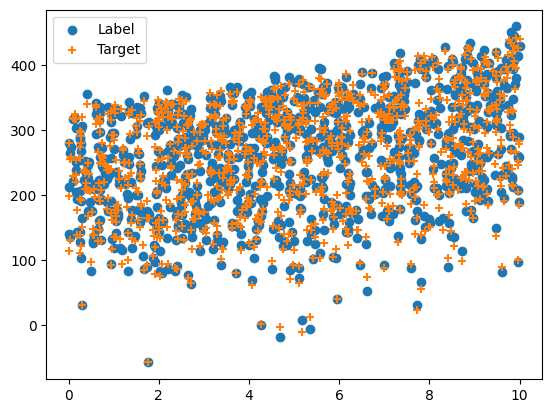

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.metrics import r2_score


SEED = 40
np.random.seed(SEED)
torch.manual_seed(SEED)

N = 10000
x1 = np.random.uniform(0,1,N).reshape(-1,1)
x2 = np.random.uniform(0,10,N).reshape(-1,1)
x3 = np.random.uniform(0,100,N).reshape(-1,1)
x = np.hstack((x1,x2,x3))
Noise = np.random.uniform(0,40,N).reshape(-1,1)


y1 = 100*np.sin(1.5*np.pi*x1)
y2 = x2**2
y3 = 50*np.log(x3+1)
y = (y1+y2+y3).reshape(-1,1)+Noise

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = 'cpu'


x_train, x_rest, y_train, y_rest = train_test_split(x,y, test_size= 0.2, random_state= SEED)
x_eval, x_test, y_eval, y_test = train_test_split(x_rest,y_rest, test_size= 0.5, random_state= SEED)

scaler_x = preprocessing.StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_eval =scaler_x.transform(x_eval)
x_test =scaler_x.transform(x_test)

scaler_y = preprocessing.StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_eval =scaler_y.transform(y_eval)
y_test =scaler_y.transform(y_test)

x_train = torch.tensor(x_train, dtype= torch.float32, device= device)
x_test = torch.tensor(x_test, dtype= torch.float32, device= device)
x_eval = torch.tensor(x_eval, dtype= torch.float32, device= device)

y_train = torch.tensor(y_train, dtype= torch.float32, device= device)
y_test = torch.tensor(y_test, dtype= torch.float32, device= device)
y_eval = torch.tensor(y_eval, dtype= torch.float32, device= device)

dataset_train = TensorDataset(x_train, y_train)
dataset_test = TensorDataset(x_test, y_test)
dataset_eval = TensorDataset(x_eval, y_eval)

dataloader_train = DataLoader(dataset_train, batch_size= 50, shuffle= True)
dataloader_test = DataLoader(dataset_test, batch_size= 50, shuffle= True)
dataloader_eval = DataLoader(dataset_eval, batch_size= 50, shuffle= True)

class MLPModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = nn.Sequential(
            nn.Linear(3,128),
            # nn.BatchNorm1d(128),
            nn.GELU(),
            # nn.ReLU(),
            # nn.LeakyReLU(.05),
            nn.Linear(128,64),
            # nn.BatchNorm1d(64),
            nn.GELU(),
            # nn.ReLU(),
            # nn.LeakyReLU(0.05), 
            # nn.Dropout(0),
            nn.Linear(64,32),
            # nn.BatchNorm1d(32),
            nn.GELU(),
            # nn.ReLU(),
            # nn.LeakyReLU(0.05), 
            # nn.Dropout(.1),
            nn.Linear(32,16),
            nn.GELU(),
            # nn.ReLU(),
            # nn.LeakyReLU(0.05),
            nn.Linear(16,1),
        )
    def forward(self, x):
        return self.model(x)

model = MLPModel().to(device)
criteria = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3, weight_decay= 1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 10, gamma= 0.5)
epochs = 80
error_train = []
error_eval = []
for epoch in tqdm(range(epochs), desc= 'Eposchs:'):
    model.train()
    epoch_loss = 0
    for xtr, ytr in dataloader_train:
        y_pred = model(xtr)
        loss = criteria(y_pred.squeeze(), ytr.squeeze())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()
    error_train.append(epoch_loss/len(dataloader_train))
    scheduler.step()

    model.eval()
    epoch_loss = 0
    for xe, ye in dataloader_eval:
        y_pred = model(xe)
        loss = criteria(y_pred, ye)
        epoch_loss += loss.item()
    error_eval.append(epoch_loss/len(dataloader_eval))


plt.figure()
plt.plot(error_train, label ='Training')
plt.plot(error_eval, label ='Evaluting')
plt.legend()
plt.show()

y_test_pred = []
x_test_plot = []
y_test_plot = []

with torch.no_grad():
    for xt, yt in dataloader_test:
        y_pred = model(xt)
        x_test_plot.extend(xt.cpu().numpy())
        y_test_plot.extend(yt.cpu().numpy())
        y_test_pred.extend(y_pred.cpu().numpy())

x_test_plot = scaler_x.inverse_transform(x_test_plot)
y_test_plot = scaler_y.inverse_transform(y_test_plot)
y_test_pred = scaler_y.inverse_transform(y_test_pred)

r2_s = r2_score(y_test_pred, y_test_plot)
print(f"R2 Score is: {r2_s: .4f}")

# print(len(y_test_pred))
plt.figure()
plt.scatter(x_test_plot[:,1], y_test_plot, label = 'Label')
plt.scatter(x_test_plot[:,1], y_test_pred, label = 'Target', marker= '+')
plt.legend()
plt.show()

